In [1]:
import os
# change to the upper level folder to detect dj_local_conf.json
if os.path.basename(os.getcwd())=='notebooks': os.chdir('..')
assert os.path.basename(os.getcwd())=='adamacs', ("Please move to the main directory")
from adamacs.pipeline import subject, session, equipment, surgery, event, trial, imaging, scan, model
from adamacs.ingest import session as isess
from adamacs.helpers import stack_helpers as sh
from adamacs.ingest import behavior as ibe
import datajoint as dj
from rspace_client.eln import eln
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
dj.__version__

[2023-05-22 12:10:42,906][INFO]: Connecting tobiasr@172.26.128.53:3306
[2023-05-22 12:10:42,953][INFO]: Connected tobiasr@172.26.128.53:3306


'0.14.0'

1. Get latest dataset from Natasha from database
2. load 2p movie to array. 
3. load top-video to array
4. find the Start and end frames of the movie with respect to the tracking gate 

In [2]:
import bisect
import numpy as np
from skimage.transform import resize
from tqdm import tqdm
import concurrent.futures
import cv2

def get_closest_timestamps(series, target_timestamp):
    # List to store the indices
    indices = []

    # For each timestamp in series1, find the closest timestamp in series2 and get its index
    for t1 in series:
        closest_index = closest_timestamp(target_timestamp, t1)
        indices.append(closest_index)
    return indices

# Function to find closest timestamp
def closest_timestamp(series, target_timestamp):
    index = bisect.bisect_left(series, target_timestamp)
    if index == 0:
        return 0
    if index == len(series):
        return len(series)-1
    before = series[index - 1]
    after = series[index]
    if after - target_timestamp < target_timestamp - before:
       return index
    else:
       return index-1


def resize_movie(movie, new_height, new_width):
    # Get the number of frames and color channels
    num_frames, _, _, num_channels = movie.shape
    
    # Initialize an empty array for the scaled movie
    scaled_movie = np.empty((num_frames, new_height, new_width, num_channels), dtype=np.uint8)
    
    # Iterate through each frame
    for i in tqdm(range(num_frames), desc="Resizing frames"):
        # Resize the frame and store it in the new array
        scaled_movie[i] =  cv2.resize(movie[i], (new_width, new_height), interpolation = cv2.INTER_AREA)
    
    # Return the scaled movie
    return scaled_movie


def resize_frame(frame, new_height, new_width):
    return cv2.resize(frame, (new_width, new_height), interpolation = cv2.INTER_AREA)

def resize_movie_mt(movie, new_height, new_width):
    num_frames, _, _, num_channels = movie.shape
    scaled_movie = np.empty((num_frames, new_height, new_width, num_channels), dtype=np.uint8)

    with concurrent.futures.ThreadPoolExecutor() as executor:
        for i, resized_frame in tqdm(enumerate(executor.map(resize_frame, movie, [new_height]*num_frames, [new_width]*num_frames)), total=num_frames, desc="Resizing frames"):
            scaled_movie[i] = resized_frame

    return scaled_movie


import numpy as np
from skimage.transform import resize
import concurrent.futures



In [3]:
# defining queries - example for latest recording sessino of specific user

# select user
user = "NK"
userquery = (session.SessionUser * subject.User() & f'initials = "{user}"')


# get the latest session
usesession = session.Session.fetch(order_by='session_datetime DESC', as_dict=True)[0]["session_id"]
sessionquery = session.Session &  f'session_id = "{usesession}"'

scansi = (scan.Scan & sessionquery).fetch('scan_id')[0]

scanquery = scan.Scan & f'scan_id = "{scansi}"'


In [4]:
# defining queries - example for directly giving scan number


scansi = "scan9FHS7Y22"

scanquery = scan.Scan & f'scan_id = "{scansi}"'


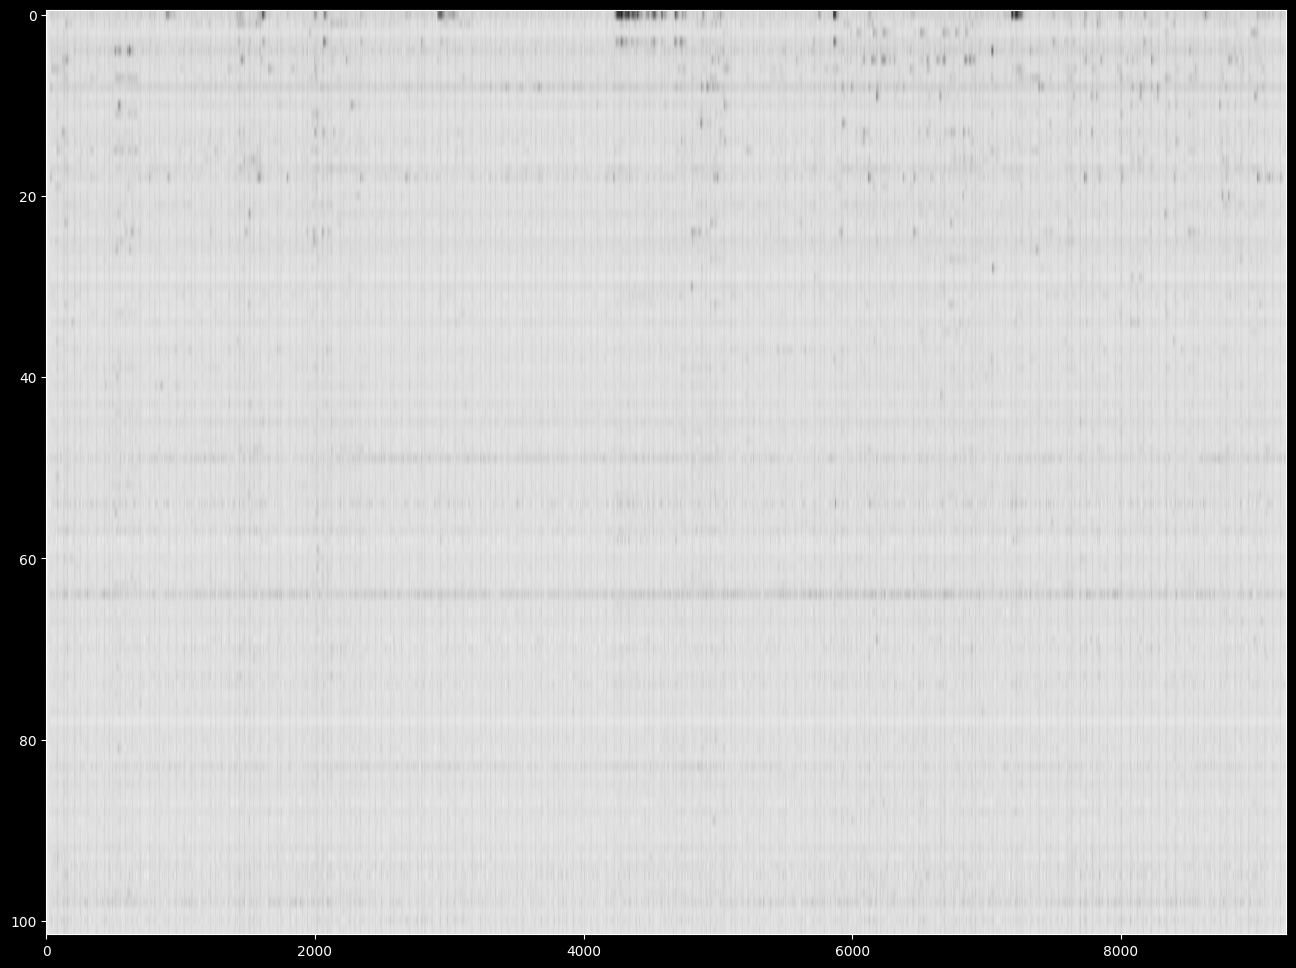

In [5]:
fluos = np.vstack((scanquery * imaging.Fluorescence.Trace).fetch("fluorescence"))
plt.figure(figsize=(16,12))
plt.imshow(fluos, aspect='auto', cmap='gray_r')

### MOVIES

In [ ]:
from pathlib import Path
import skvideo.io

# get the main data directory of the specified scanID 

dir = (scan.ScanPath & scanquery).fetch('path')

# get the top cam movie of that session
directory = Path(dir[0])
pattern = '*top_video*.mp4'
files = list(directory.glob(pattern))

#load to array
videodata = skvideo.io.vread(str(files[0]))
videodata = np.asarray([skvideo.io.vshape(frame)[0] for frame in videodata], dtype=np.uint8)

In [ ]:
# get the registered moving average (blinking) movie data of the specified scanID
directory = Path(dir[0] + "/suite2p/plane0/reg_tif")
pattern = '*40_frame*.mp4'
files = list(directory.glob(pattern))
blinkvideodata = skvideo.io.vread(str(files[0]))
blinkvideodata = np.asarray([skvideo.io.vshape(frame)[0] for frame in blinkvideodata], dtype=np.uint8)

#dimensionts of the original movie (frames, x,y,rgb)
print(videodata.shape)
print(blinkvideodata.shape)

In [ ]:
# display camaravideo with slider
sh.display_volume_z(videodata,1)

In [ ]:
# display 2pstackvideo with slider
sh.display_volume_z(blinkvideodata,1)

#### Synchronization!

In [7]:
## Get the timestamp data and gate / offset cameraframes

# from the event table get the main recording gate start / end timestamps.
auxgatetimestamp_end = (event.Event()  &  "event_type='main_track_gate'" &  scanquery ).fetch('event_end_time')
auxgatetimestamp_start = (event.Event()  &  "event_type='main_track_gate'" &  scanquery ).fetch('event_start_time')

# Then return camera start timestamps within the recording gate only 
cameratimestamps = (event.Event()  &  "event_type='aux_cam'" & f"event_start_time>{auxgatetimestamp_start[0]}" & f"event_start_time<{auxgatetimestamp_end[0]}" & scanquery).fetch('event_start_time')

#  and 2p timestamps (which will always be in the recording gate).
twoptimestamps = (event.Event()  &  "event_type='mini2p_frames'" &  scanquery ).fetch('event_start_time')

#  Zero camera timestamps on first 2p timestamp. (not necessary)
# cameratimestamps = cameratimestamps - twoptimestamps[0]
# twoptimestamps = twoptimestamps - twoptimestamps[0]

In [28]:
# align the two recordings by finding the indices of the closest camera timestamp that fits the 2p frame timestamps by sorted list insertion ("bisect"). Be aware: camera frames can be double.
aligned_cameraframes = get_closest_timestamps(twoptimestamps,cameratimestamps)

# this should have the same shape as the 2p frames:
print(np.shape(aligned_cameraframes))


(9230,)


In [29]:

# now use this camara frame indices to reslice the video (which now is aligned to the 2p frames on a frame-by-frame level)
resliced_cam_video = videodata[aligned_cameraframes]

NameError: name 'videodata' is not defined

In [30]:
# display synchronized movie
sh.display_volume_z(resliced_cam_video,1)

NameError: name 'resliced_cam_video' is not defined

In [ ]:
# rescale camera movie to fit size of 2p movie (can take a lot of time and memory)
rescaled_cam_movie = resize_movie(resliced_cam_video, np.shape(blinkvideodata)[1],np.shape(blinkvideodata)[2])

In [ ]:
# concatenate and display movies
concatmovie = np.concatenate((blinkvideodata,rescaled_cam_movie), axis = 2)
sh.display_volume_z(concatmovie,1)

In [ ]:
#save as new movie (without rescaling)


filename = str(directory) + '/aligned_stack_cam_movie.mp4'
fps = (scan.ScanInfo & scanquery).fetch('fps')
# p1 = 0
# p2 = 100
# trash = sh.make_stack_movie(concatmovie, filename, fps[0], p1, p2)

codecset = 'libx264'
import imageio
import imageio.plugins.ffmpeg as ffmpeg

# Create an imageio VideoWriter object to write the video
writer = imageio.get_writer(filename, fps=fps[0], codec=codecset, output_params=['-crf', '19'])

# # Calculate the 1st and 99th percentile
# p1, p99 = np.percentile(running_z_projection[:500,:,:], (p1set, p2set))

# # rescale to 8 bit
# rescaled_image_8bit = rescale_image_multithreaded(running_z_projection, p1, p99)

for page in concatmovie:
    writer.append_data(page)

# Close the video writer
writer.close()


In [ ]:
# speed up, add timestamps etc - all with fast ffmpeg operations

import os

spedby = 5
setpts_value = 1/spedby # change this to your desired value
newfps = fps[0]*spedby

input_filename = filename
# 2. Add timestamps

output_filename = str(directory) + '/' + scansi + '_top_video_concatenated' + 'withtimestamps.mp4'
command = f"""ffmpeg -y -i {input_filename} -vf "drawtext=fontfile=/Library/Fonts/Arial.ttf:timecode='00\\\\:00\\\\:00\\\\:00':rate={fps[0]}:text='':fontsize=14:fontcolor=white:x=270:y=10:box=1:boxcolor=0x00000000@1" -f mp4 {output_filename}"""

os.system(command)


input_filename = output_filename  # 'sped_up_video.mp4'
output_filename = str(directory) + '/' +  scansi + '_top_video_concatenated_spedup_' + str(spedby) + 'fold_withtimestamps.mp4'

command = f'ffmpeg -y -i {input_filename} -vf "setpts={setpts_value}*PTS" -r {newfps}  {output_filename}'



os.system(command)


###  Synchronization of Flash stimulus with 2p data

In [15]:
event.EventType()

event_type,event_type_description
arena_LED,
aux_bpod_cam,
aux_bpod_reward,
aux_bpod_tone,
aux_bpod_visual,
aux_cam,
HARP_gate,
main_track_gate,
mini2p_frames,
mini2p_lines,


In [25]:
## Get the timestamp data and gate / offset cameraframes

# from the event table get the main recording gate start / end timestamps.
auxgatetimestamp_end = (event.Event()  &  "event_type='main_track_gate'" &  scanquery ).fetch('event_end_time')
auxgatetimestamp_start = (event.Event()  &  "event_type='main_track_gate'" &  scanquery ).fetch('event_start_time')

# Then return FlashStim start timestamps within the recording gate only 
flashtimestamps = (event.Event()  &  "event_type='arena_LED'" & f"event_start_time>{auxgatetimestamp_start[0]}" & f"event_start_time<{auxgatetimestamp_end[0]}" & scanquery).fetch('event_start_time')

#  and 2p timestamps (which will always be in the recording gate).
twoptimestamps = (event.Event()  &  "event_type='mini2p_frames'" &  scanquery ).fetch('event_start_time')



In [31]:
print(flashtimestamps)

[  3.8   7.9  11.   12.7  16.2  18.9  22.5  26.8  30.6  32.9  34.5  38.2
  40.7  44.1  47.9  52.4  55.   57.2  61.7  65.4  69.2  72.7  74.4  77.8
  82.   84.3  87.1  90.9  93.8  96.   98.3 100.9 102.9 105.9 110.1 114.4
 116.  120.3 123.3 126.4 128.8 133.3 136.3 138.6 140.3 144.7 146.4 149.4
 152.  154.3 158.6 161.7 164.6 169.  170.6 174.4 178.2 182.2 184.  185.5
 189.1 193.2 196.6 200.3 204.  208.5 212.7 214.9 217.3 219.8 222.8 226.1
 230.2 232.9 237.  239.3 242.  245.1 248.  250.3 252.3 254.2 257.4 261.3
 262.9 266.  269.  273.4 277.2 280.4 284.6 288.  292.1 294.  296.1 299.8
 301.7 303.4 305.7 307.2 309.9 311.4 315.1 319.5 321.7 323.7 326.1 330.3
 333.8 335.7 339.3 341.9 344.6 347.6 349.5 352.8 356.9 360.2 364.6 367.8
 369.7 374.2 376.9 378.8 382.  384.2 387.2 390.1 394.5 396.3 398.4 400.8
 404.2 406.  409.5 412.9 416.8 419.  421.9 424.6 426.7 428.2 432.4 435.2
 437.1 441.5 444.2 446.1 450.3 452.  454.  455.7 458.3 460.5 462.4 466.3
 469.2 471.7 474.6 478.6 482.9 486.4 488.5 492.1 49

In [26]:
# now get the 2p frame indices that correspond most closely to these timestamps
flash_aligned_2pframes = get_closest_timestamps(flashtimestamps, twoptimestamps)

# this should have the same shape as the 2p frames:
print(np.shape(flash_aligned_2pframes))

(195,)


In [27]:
print(flash_aligned_2pframes)

[19, 83, 130, 156, 210, 252, 307, 373, 432, 467, 492, 549, 587, 639, 698, 767, 807, 841, 910, 967, 1026, 1079, 1106, 1158, 1223, 1258, 1301, 1359, 1404, 1438, 1473, 1513, 1544, 1590, 1655, 1721, 1746, 1812, 1858, 1906, 1942, 2012, 2058, 2093, 2119, 2187, 2213, 2259, 2299, 2335, 2401, 2449, 2493, 2561, 2586, 2644, 2702, 2764, 2792, 2815, 2870, 2933, 2986, 3042, 3099, 3169, 3233, 3267, 3304, 3342, 3389, 3439, 3502, 3544, 3607, 3642, 3684, 3732, 3776, 3812, 3842, 3872, 3921, 3981, 4006, 4053, 4099, 4167, 4226, 4275, 4339, 4392, 4455, 4484, 4516, 4573, 4602, 4629, 4664, 4687, 4729, 4752, 4809, 4876, 4910, 4941, 4978, 5042, 5096, 5126, 5181, 5221, 5262, 5309, 5338, 5389, 5452, 5502, 5570, 5619, 5649, 5718, 5759, 5789, 5838, 5872, 5918, 5962, 6030, 6058, 6090, 6127, 6179, 6207, 6261, 6313, 6373, 6407, 6452, 6493, 6526, 6549, 6613, 6656, 6686, 6753, 6795, 6824, 6889, 6915, 6946, 6972, 7012, 7046, 7075, 7135, 7179, 7218, 7262, 7324, 7390, 7444, 7476, 7532, 7598, 7632, 7695, 7739, 7786, 7836, 7

### IMU